# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [1]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import pprint
from scipy.stats import poisson

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [12]:
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)
print(n_cells)

100


In [13]:
# Select random fraction of data samples
def sub_sample(size = 15, n_cells = 100):
    subset_indices = np.sort(np.random.choice(n_cells, size))
    return subset_indices

subset_indices = sub_sample(15, n_cells)
print(subset_indices)

[ 1  4 15 31 33 34 40 41 41 58 67 75 84 90 98]


In [14]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
#interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))
interact(plot_unit, i=widgets.SelectionSlider(options=subset_indices, value=subset_indices[0]))

interactive(children=(SelectionSlider(description='i', options=(1, 4, 15, 31, 33, 34, 40, 41, 41, 58, 67, 75, …

<function __main__.plot_unit(i)>

100%|██████████| 5026/5026 [00:09<00:00, 516.39it/s]


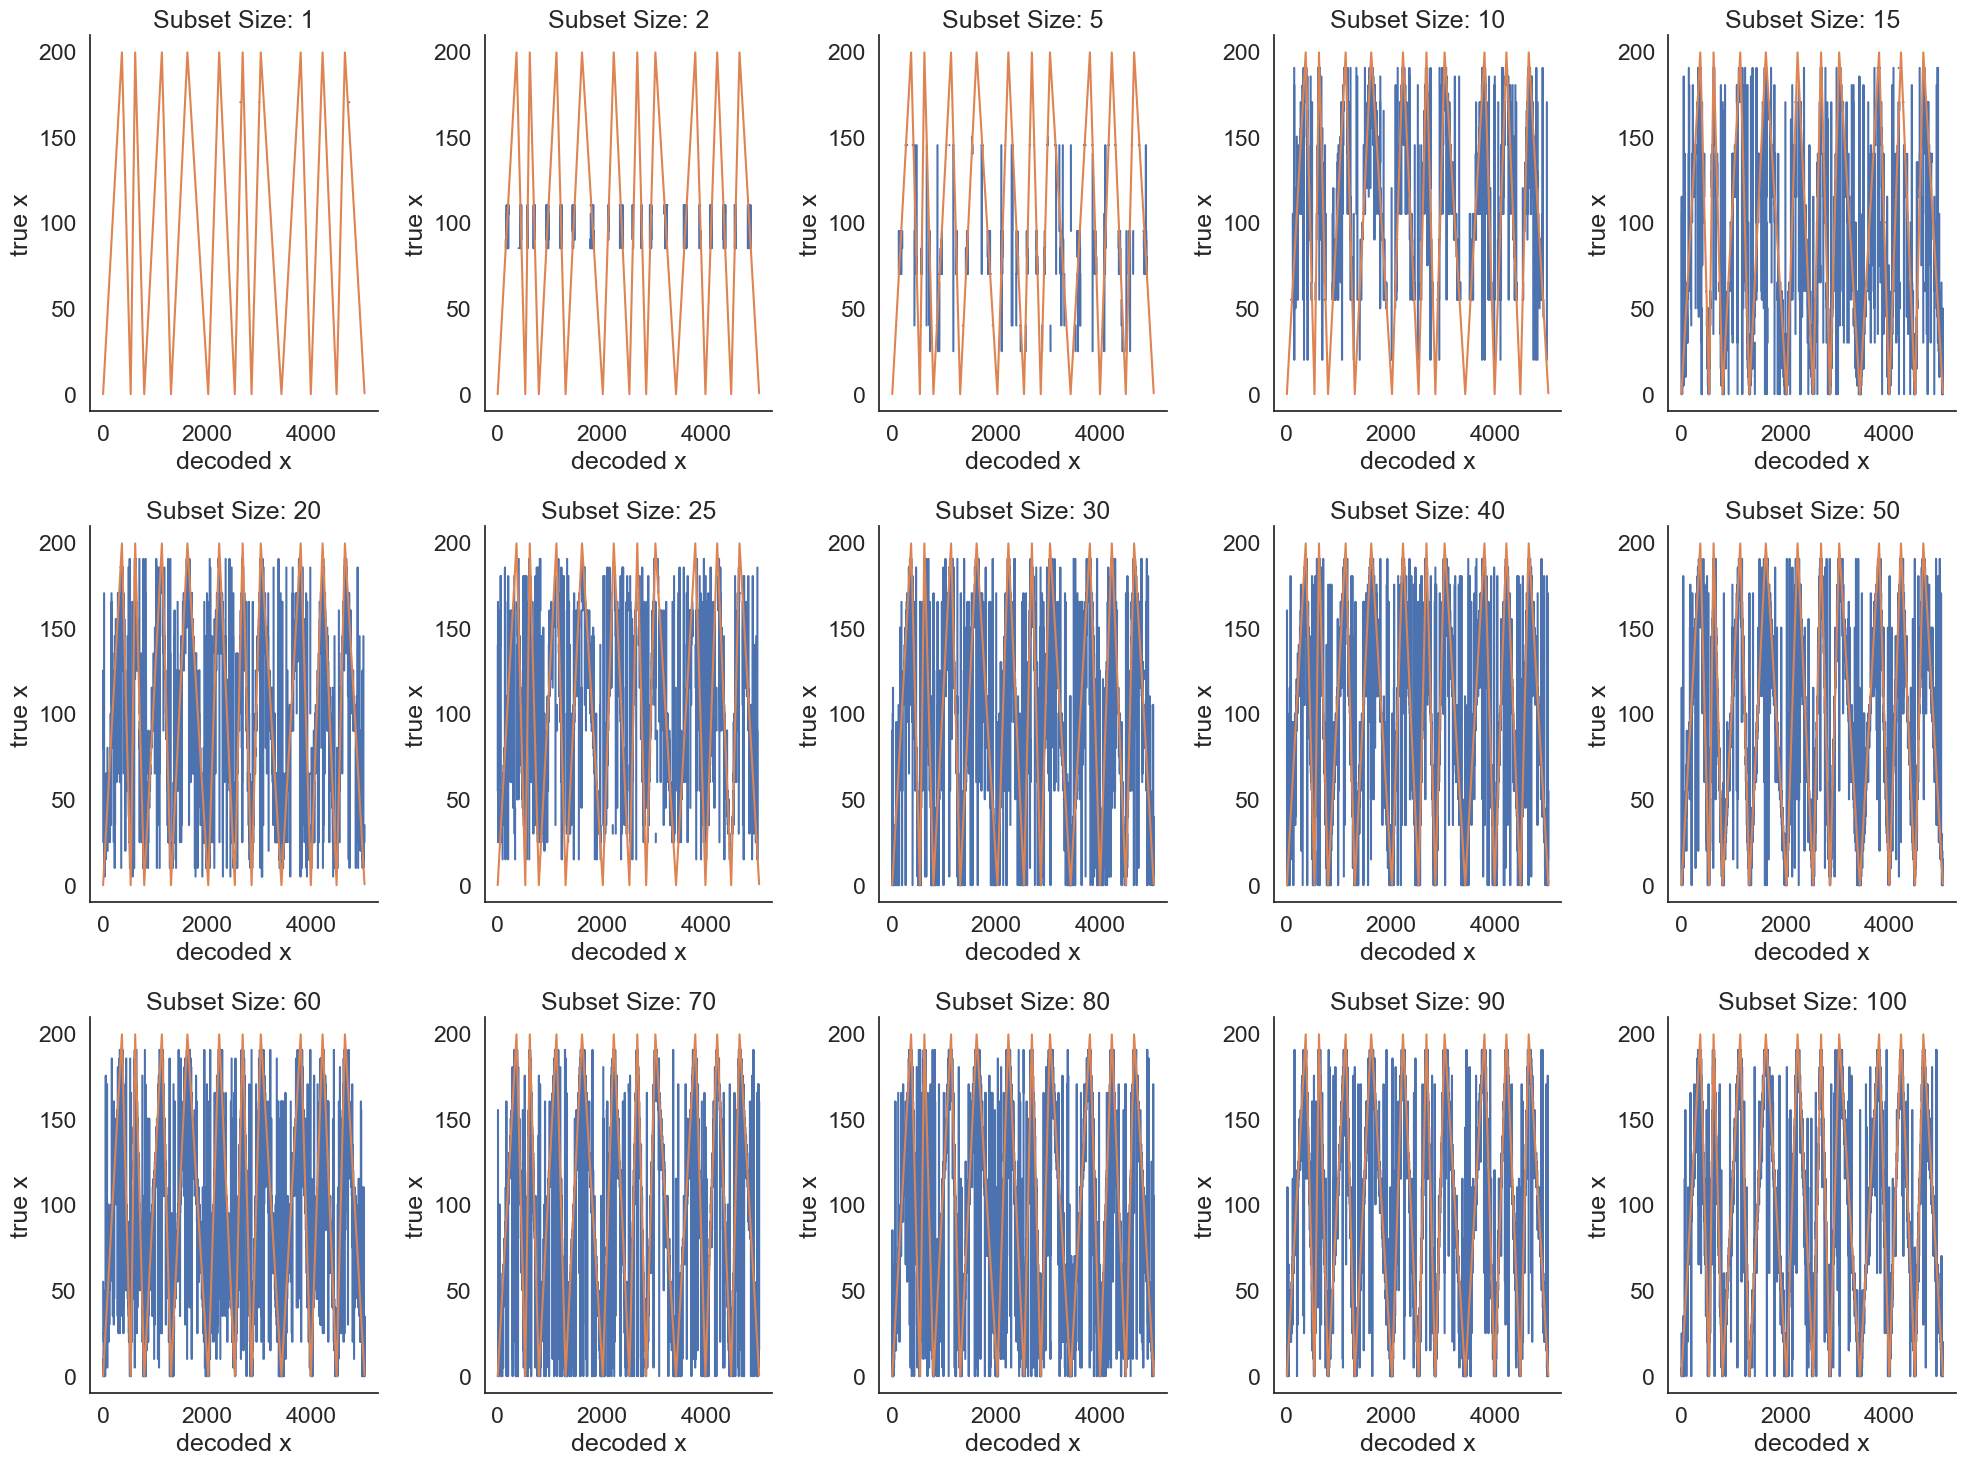

In [15]:
# A
# Decode x for several subsets
def decode(x, t, spikes, track_length, fps):

    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms
    
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
    
    # code decoding
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    
    x_decoded = np.zeros_like(true_x)
    
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
    
            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
    
    
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
    return x_decoded, true_x



def plot_decodedx(subset_sizes):
    xs_decoded = []
    for i, size in enumerate(subset_sizes):
        indices = sub_sample(size, n_cells)
        spikes_subset = [np.array(spikes[s]) for s in indices]
        x_decoded, true_x = decode(x, t, spikes_subset, track_length, fps)
        xs_decoded.append(x_decoded)
    
    n_subplots = len(subset_sizes)
    n_cols = 5
    n_rows = (n_subplots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, size in enumerate(subset_sizes):
        ax = axes[i]
        ax.plot(xs_decoded[i])
        ax.plot(true_x)
        ax.set_title(f'Subset Size: {size}')
        ax.set_xlabel('decoded x')
        ax.set_ylabel('true x')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
    return xs_decoded, true_x
    
subset_sizes = [1,2,5,10,15,20,25,30,40,50,60,70,80,90,100]    
xs_decoded, true_x = plot_decodedx(subset_sizes)

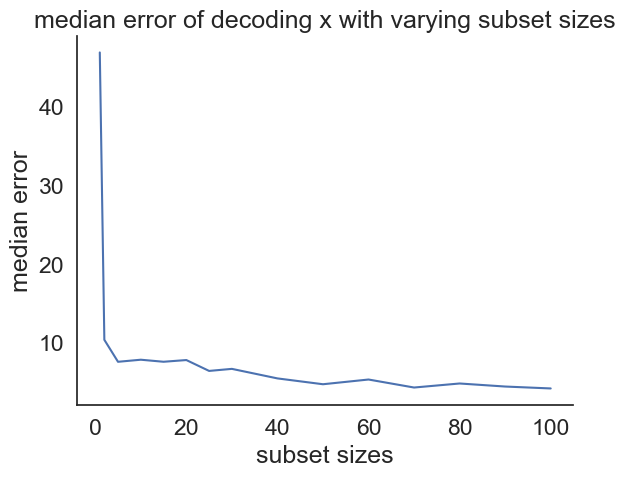

In [16]:
# Calculate median errors
mses = np.sqrt((true_x-xs_decoded)**2)
plt.plot(subset_sizes, np.nanmedian(mses, axis = 1))
plt.xlabel('subset sizes')
plt.ylabel('median error')
plt.title('median error of decoding x with varying subset sizes')
plt.show()

The median error goes down drastically and then gradually goes down as the subset size increases. At full size the median error ideally is approximately 3. However, re-running the code above will not always give that result as every subset is only sampled once.

100%|██████████| 5026/5026 [00:05<00:00, 1004.20it/s]


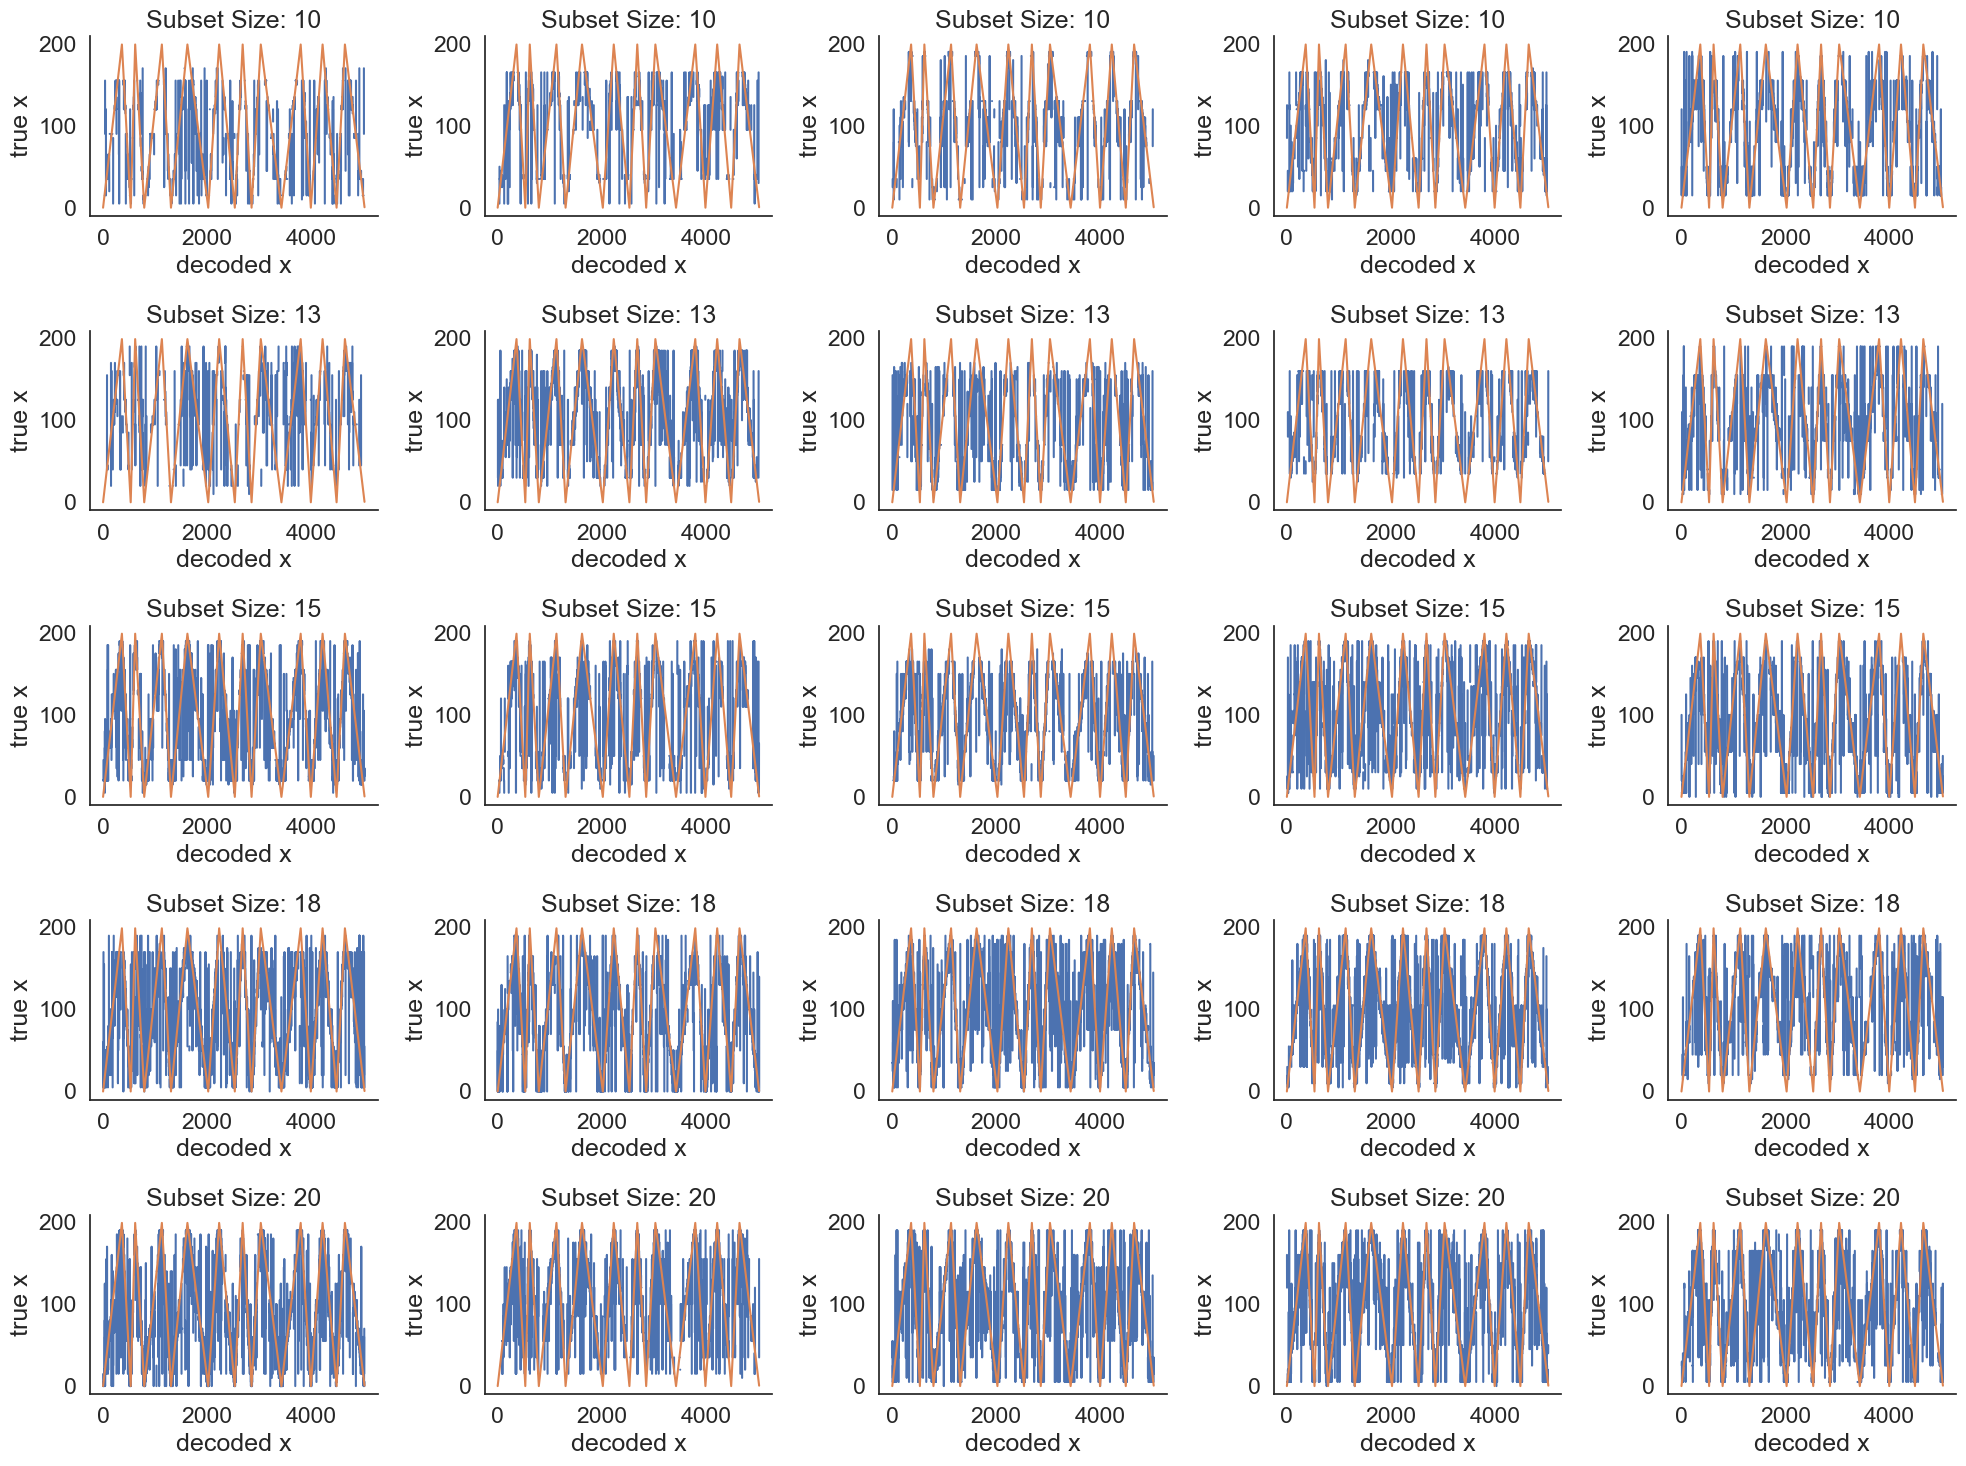

In [17]:
# B
reps = 5
subset_sizes = [10]*reps + [13]*reps + [15]*reps + [18]*reps + [20]*reps
xs_decoded, true_x = plot_decodedx(subset_sizes)

5026
[10, 13, 15, 18, 20]


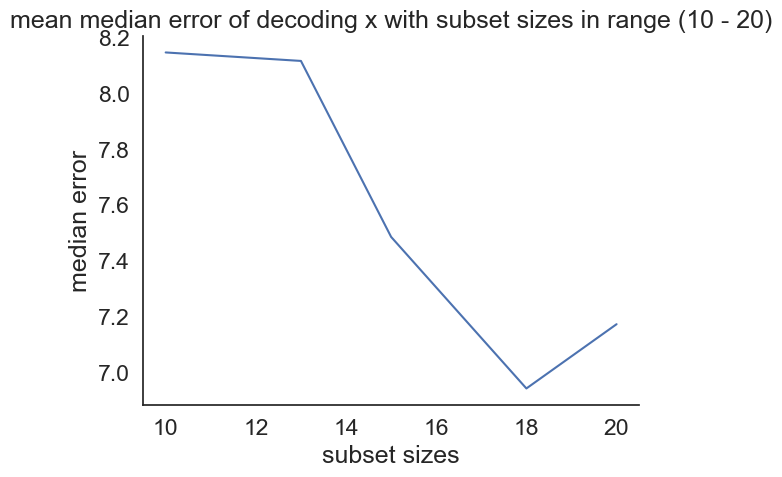

In [18]:
mses = np.sqrt((true_x-xs_decoded)**2)
chunks = [mses[i:i + reps] for i in range(0, len(mses), reps)]
print(len(chunks[0][0]))
mean_medians = [np.mean(np.nanmedian(chunk)) for chunk in chunks]
#error_medians = [np.std(np.nanmedian(chunk)) for chunk in chunks] 
sizes = [subset_sizes[i] for i in range(0, len(subset_sizes), reps)]
plt.plot(sizes, mean_medians)
print(sizes)
plt.xlabel('subset sizes')
plt.ylabel('median error')
plt.title('mean median error of decoding x with subset sizes in range (10 - 20)')
plt.show()

The median error goes down quite a bit (from 8 to 7) when the subset size increases from 10 to 20.

In [19]:
# C
# generated new data with the name 'linear_track_data_(index).pickle'
# files are created to save time when re-executing the cells below
# default nfr was 0.1, chosen minimum is 0.05 and goes up to 1 in steps.

# copied code from generating data (needs to be run at least once)
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])

for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

# generate new data 
nfrs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

def gen_samples(nfr, index):
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    noise_firing_rate = nfr # the baseline noise firing rate
    spikes = []
    
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    file_name = f'linear_track_data_{index}.pickle' # change this name when you save new data
    
    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps
    
    with open('data/'+file_name,'wb') as f:
        pickle.dump(out_data,f)

for i, nfr in enumerate(nfrs):
    gen_samples(nfr, i)

100%|██████████| 4257/4257 [00:07<00:00, 549.01it/s]


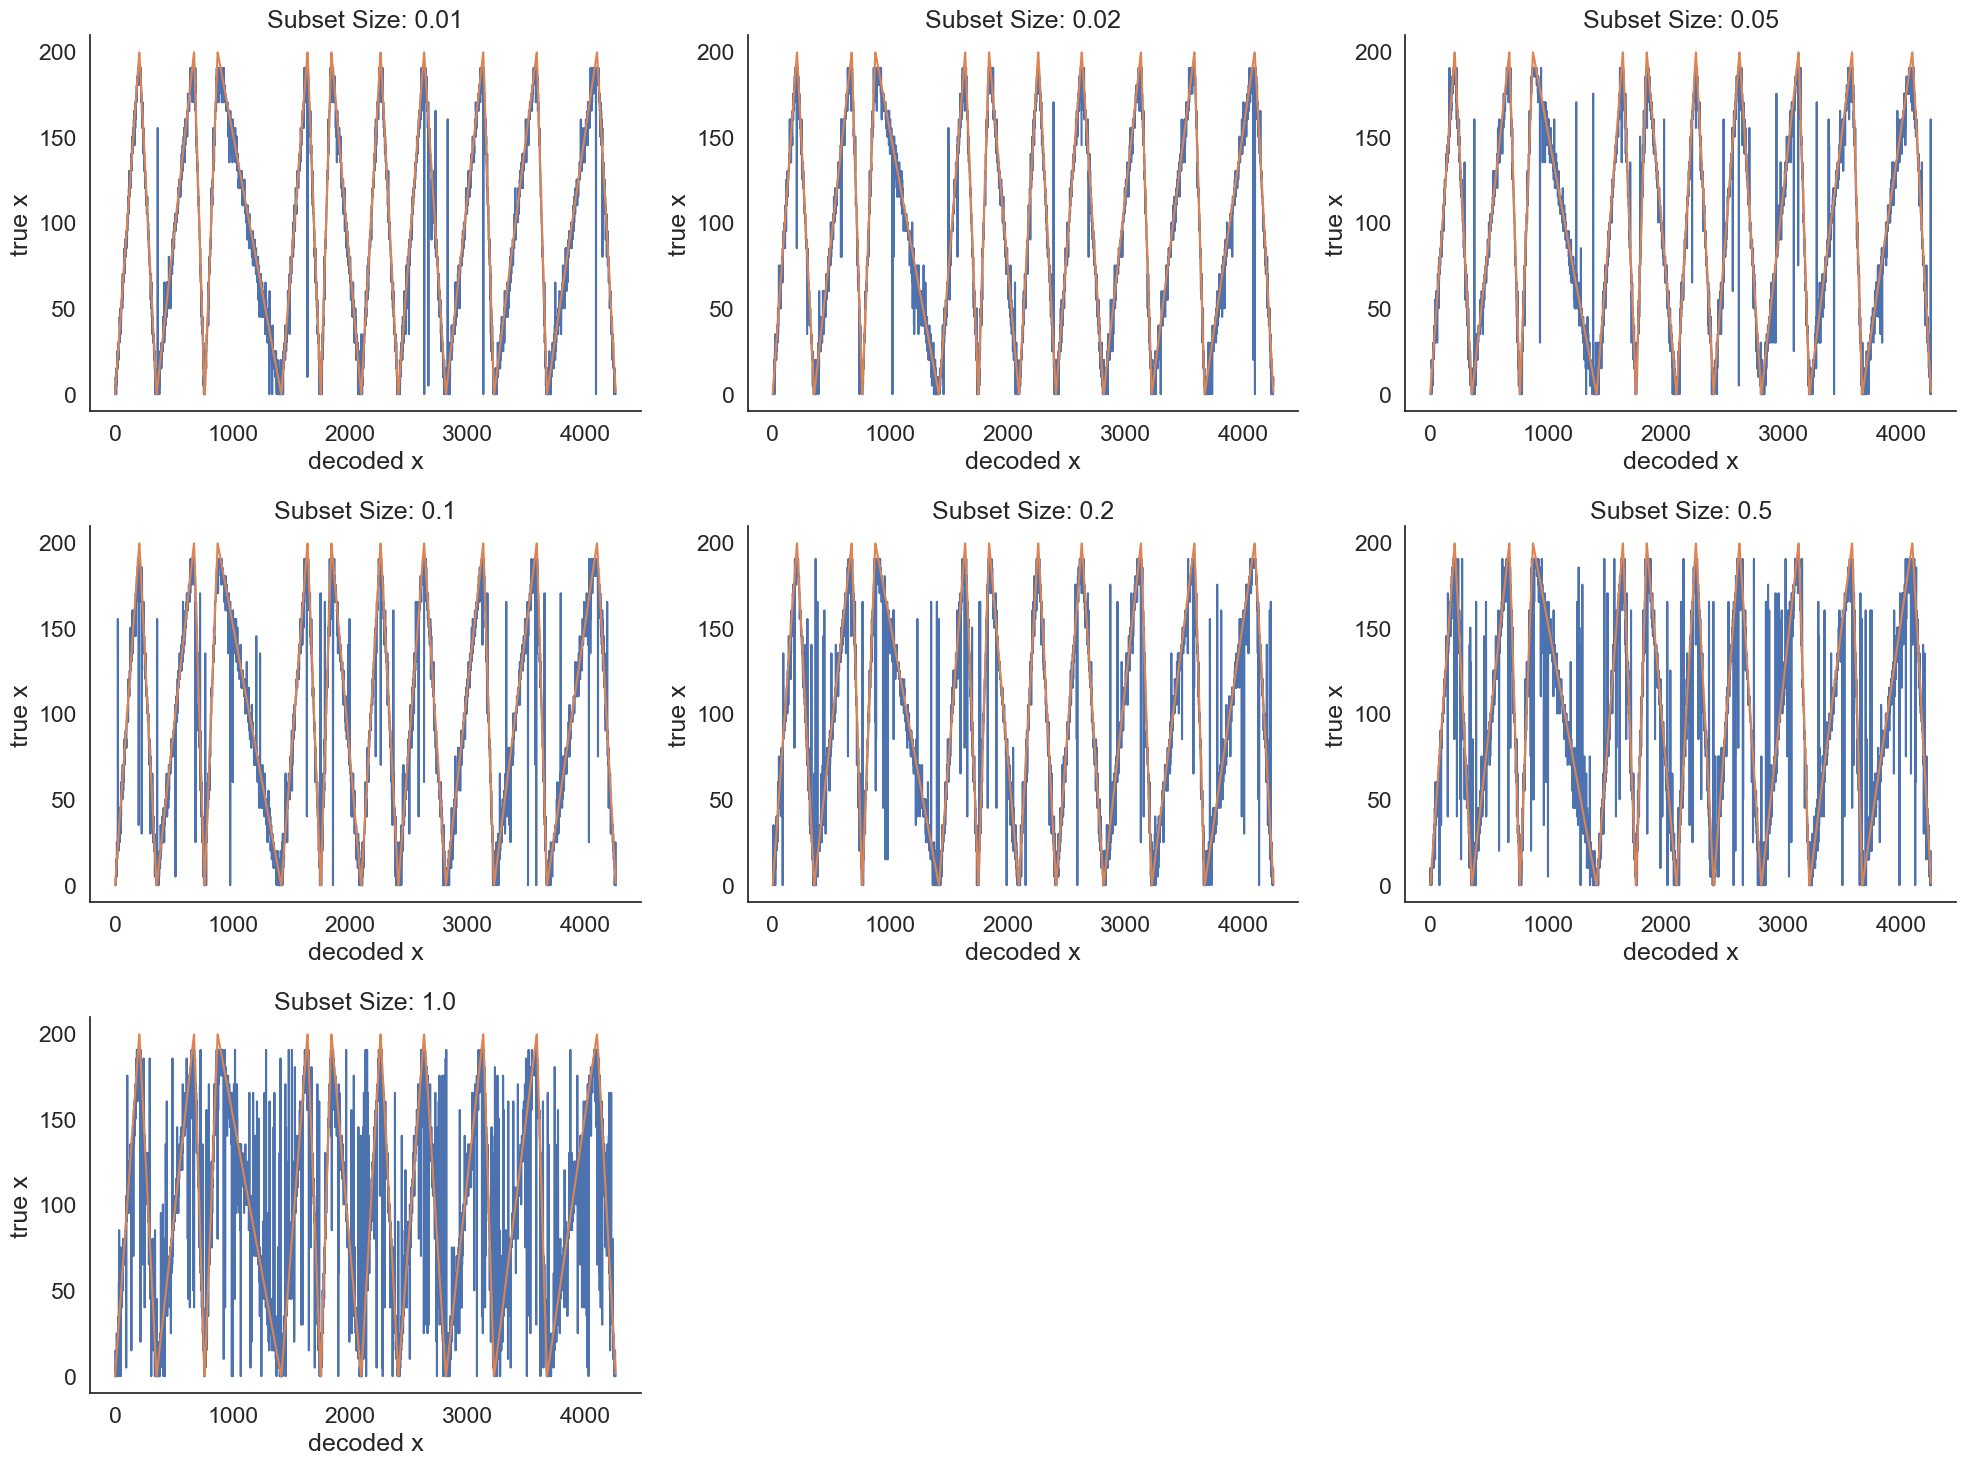

In [20]:
nfrs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
def extract_data(data):
    x,t,spikes = data['x'],data['t'],data['spikes']
    track_length = data['track_length']
    fps = data['fps'] 
    n_cells = len(spikes)
    return x, t, spikes, track_length, fps, n_cells

n_subplots = len(nfrs)
n_cols = 3
n_rows = (n_subplots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

xs_decoded = []
for i, nfr in enumerate(nfrs):
    data_file = f'data/linear_track_data_{i}.pickle'
    with open(data_file, 'rb') as handle:
        data = pickle.load(handle)
    x, t, spikes, track_length, fps, n_cells = extract_data(data)
    x_decoded, true_x = decode(x, t, spikes, track_length, fps)
    xs_decoded.append(x_decoded)
    ax = axes[i]
    ax.plot(xs_decoded[i])
    ax.plot(true_x)
    ax.set_title(f'Subset Size: {nfr}')
    ax.set_xlabel('decoded x')
    ax.set_ylabel('true x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Subset Size is supposed to be replaced with nfrs in the titles.

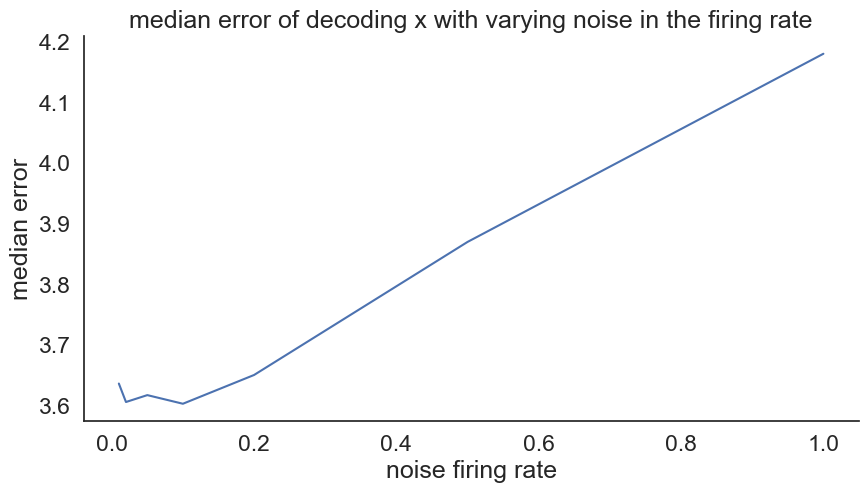

In [21]:
# Calculate median errors
mses = np.sqrt((true_x-xs_decoded)**2)
plt.plot(nfrs, np.nanmedian(mses, axis = 1))
plt.xlabel('noise firing rate')
plt.ylabel('median error')
plt.title('median error of decoding x with varying noise in the firing rate')
plt.show()

When the noise in the firing rate increases, the median error does as well, however only a change of 3.6 to 4.2.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation

In [18]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [19]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [24]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [25]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [26]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)